Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import numpy as np
import requests

from keras.callbacks import History 
history = History()


API_KEY = 'ei_34549284a9dad952ca4af9d9f859d70eb37746c157032f261972412d21df25e6'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/86484/training/65/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/86484/training/65/y')


2022-03-15 14:16:00.388852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 14:16:00.388920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Store the data in a temporary file, and load it back through Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [3]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "Fire", "Noise", "Unknown", "Weather" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


2022-03-15 14:16:19.203726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-15 14:16:19.203780: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 14:16:19.203819: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PC-Matt): /proc/driver/nvidia/version does not exist
2022-03-15 14:16:19.204204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the model:

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
channels = 1
columns = 65
rows = int(input_length / (columns * channels))
model.add(Reshape((rows, columns, channels), input_shape=(input_length, )))
model.add(Conv2D(8, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(16, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False


Epoch 1/200
113/113 - 2s - loss: 0.7855 - accuracy: 0.6784 - val_loss: 0.3981 - val_accuracy: 0.8700 - 2s/epoch - 16ms/step
Epoch 2/200
113/113 - 1s - loss: 0.4135 - accuracy: 0.8569 - val_loss: 0.2891 - val_accuracy: 0.8978 - 1s/epoch - 10ms/step
Epoch 3/200
113/113 - 1s - loss: 0.3184 - accuracy: 0.8874 - val_loss: 0.2792 - val_accuracy: 0.8978 - 1s/epoch - 10ms/step
Epoch 4/200
113/113 - 1s - loss: 0.2962 - accuracy: 0.8916 - val_loss: 0.2785 - val_accuracy: 0.8978 - 1s/epoch - 12ms/step
Epoch 5/200
113/113 - 1s - loss: 0.2482 - accuracy: 0.9147 - val_loss: 0.2446 - val_accuracy: 0.9156 - 1s/epoch - 10ms/step
Epoch 6/200
113/113 - 1s - loss: 0.2202 - accuracy: 0.9241 - val_loss: 0.2182 - val_accuracy: 0.9222 - 1s/epoch - 9ms/step
Epoch 7/200
113/113 - 1s - loss: 0.1933 - accuracy: 0.9347 - val_loss: 0.2239 - val_accuracy: 0.9244 - 1s/epoch - 10ms/step
Epoch 8/200
113/113 - 1s - loss: 0.1752 - accuracy: 0.9386 - val_loss: 0.2188 - val_accuracy: 0.9344 - 1s/epoch - 9ms/step
Epoch 9/20

Epoch 67/200
113/113 - 1s - loss: 0.0619 - accuracy: 0.9811 - val_loss: 0.3666 - val_accuracy: 0.9322 - 964ms/epoch - 9ms/step
Epoch 68/200
113/113 - 1s - loss: 0.0387 - accuracy: 0.9833 - val_loss: 0.3955 - val_accuracy: 0.9333 - 959ms/epoch - 8ms/step
Epoch 69/200
113/113 - 1s - loss: 0.0534 - accuracy: 0.9794 - val_loss: 0.4045 - val_accuracy: 0.9367 - 1s/epoch - 9ms/step
Epoch 70/200
113/113 - 1s - loss: 0.0390 - accuracy: 0.9864 - val_loss: 0.3743 - val_accuracy: 0.9356 - 1s/epoch - 10ms/step
Epoch 71/200
113/113 - 1s - loss: 0.0560 - accuracy: 0.9797 - val_loss: 0.4145 - val_accuracy: 0.9322 - 1s/epoch - 9ms/step
Epoch 72/200
113/113 - 1s - loss: 0.0760 - accuracy: 0.9750 - val_loss: 0.3311 - val_accuracy: 0.9367 - 1s/epoch - 10ms/step
Epoch 73/200
113/113 - 1s - loss: 0.0332 - accuracy: 0.9867 - val_loss: 0.3732 - val_accuracy: 0.9344 - 1s/epoch - 10ms/step
Epoch 74/200
113/113 - 1s - loss: 0.0242 - accuracy: 0.9903 - val_loss: 0.3667 - val_accuracy: 0.9467 - 1s/epoch - 10ms/ste

Epoch 133/200
113/113 - 1s - loss: 0.0317 - accuracy: 0.9894 - val_loss: 0.3639 - val_accuracy: 0.9444 - 937ms/epoch - 8ms/step
Epoch 134/200
113/113 - 1s - loss: 0.0292 - accuracy: 0.9875 - val_loss: 0.3164 - val_accuracy: 0.9422 - 931ms/epoch - 8ms/step
Epoch 135/200
113/113 - 1s - loss: 0.0336 - accuracy: 0.9875 - val_loss: 0.3691 - val_accuracy: 0.9444 - 974ms/epoch - 9ms/step
Epoch 136/200
113/113 - 1s - loss: 0.0392 - accuracy: 0.9869 - val_loss: 0.3418 - val_accuracy: 0.9389 - 952ms/epoch - 8ms/step
Epoch 137/200
113/113 - 1s - loss: 0.0229 - accuracy: 0.9919 - val_loss: 0.2957 - val_accuracy: 0.9456 - 926ms/epoch - 8ms/step
Epoch 138/200
113/113 - 1s - loss: 0.0291 - accuracy: 0.9903 - val_loss: 0.3370 - val_accuracy: 0.9389 - 946ms/epoch - 8ms/step
Epoch 139/200
113/113 - 1s - loss: 0.0546 - accuracy: 0.9830 - val_loss: 0.3263 - val_accuracy: 0.9422 - 976ms/epoch - 9ms/step
Epoch 140/200
113/113 - 1s - loss: 0.0407 - accuracy: 0.9855 - val_loss: 0.3658 - val_accuracy: 0.9267 -

Epoch 198/200
113/113 - 1s - loss: 0.0150 - accuracy: 0.9936 - val_loss: 0.4042 - val_accuracy: 0.9467 - 1s/epoch - 9ms/step
Epoch 199/200
113/113 - 1s - loss: 0.0164 - accuracy: 0.9933 - val_loss: 0.4438 - val_accuracy: 0.9356 - 980ms/epoch - 9ms/step
Epoch 200/200
113/113 - 1s - loss: 0.0453 - accuracy: 0.9858 - val_loss: 0.4895 - val_accuracy: 0.9367 - 971ms/epoch - 9ms/step


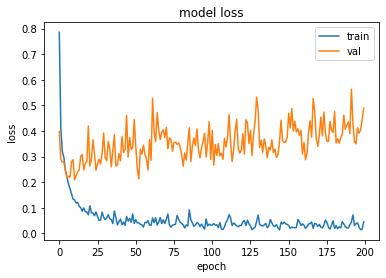

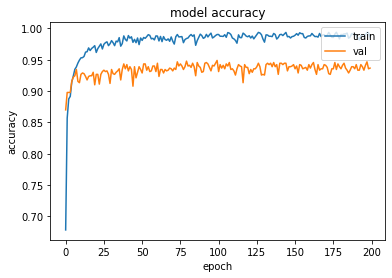

In [5]:
import keras
from matplotlib import pyplot as plt

loss=history.history['loss']
loss=loss[:200]
plt.plot(loss)
val_loss=history.history['val_loss']
val_loss=val_loss[:200]
plt.plot(val_loss)



plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

acc=history.history['accuracy']
acc=acc[:200]
plt.plot(acc)
vacc=history.history['val_accuracy']
vacc=vacc[:200]
plt.plot(vacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()